# Registration Lab
## Load the NIFTI images

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import rotate

In [3]:
ct_file = nib.load("ct.nii")
mr_file1 = nib.load("mr1.nii")
mr_file2 = nib.load("mr2.nii")

In [4]:
print(ct_file.shape)
print(mr_file1.shape)
print(mr_file2.shape)

(271, 271, 221)
(164, 241, 241)
(165, 240, 241)


In [5]:
print(ct_file.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'?TR:0.000 TE:0.00'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 271 271 221   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 0.000000e+00
 1.000000e+00 1.000000e+00 3.879853e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 4095
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 

In [6]:
ct_img = ct_file.get_fdata()
mr_img1 = mr_file1.get_fdata()
mr_img2 = mr_file2.get_fdata()
print(ct_img.shape)

(271, 271, 221)


(<AxesSubplot:>,
 (-0.5, 239.5, 164.5, -0.5))

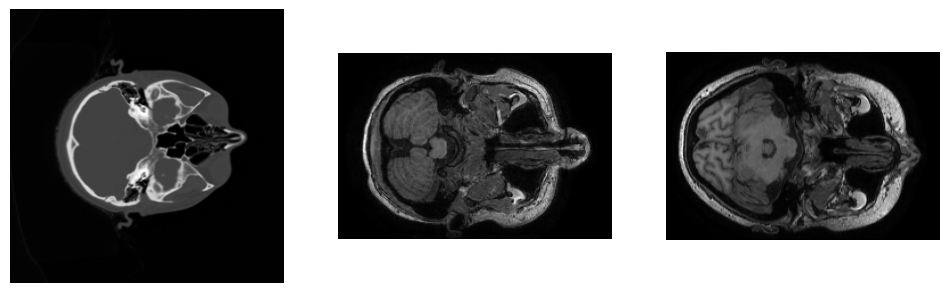

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1), plt.imshow(ct_img[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(mr_img2[:, :, 100], cmap='gray'), plt.axis('off')

## Functions
### Interpolation

In [8]:
def bilinear_interpolation(img, interpolation_points):
    """ Performs bilinear interpolation on a given image at all the coordinates.
    Parameters
    ----------
    image : ndarray
        The image on which to perform interpolation.
    interpolation_points : ndarray
        Contains the coordinates (x, y) of the points where the interpolation will be placed."""
    
    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    X, Y = np.meshgrid(x, y)
    original_points = np.column_stack((X.flatten(), Y.flatten()))
    interpolated_img = griddata(original_points, img.flatten(), interpolation_points, method='linear', fill_value=0)
    
    return interpolated_img

### Transform

In [109]:
def rotate_transform(img, rot_angles=(0, 0.5)): 
    """Rotates an image for registration algorithms.
    Parameters:
    - img: 2D array 
        img to be rotated
    - angle: float
        angles (in degrees) in x and y planes to be rotated
    Returns: rotated_img, 2D array
    """
    
    x_rot = np.array([[1, 0, 0], 
        [0, np.cos(rot_angles[0]), -np.sin(rot_angles[0])],
        [0, np.sin(rot_angles[0]), np.cos(rot_angles[0])]])
    y_rot = np.array([[np.cos(rot_angles[1]), 0, np.sin(rot_angles[1])], 
            [0, 1, 0], 
            [-np.sin(rot_angles[1]), 0, np.cos(rot_angles[1])]])
    
    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    trans_img = np.zeros(img.shape)
    
    x, y = np.meshgrid(x, y)
    
    original_points = np.column_stack((x.flatten(), y.flatten()))
    
    new_points = []
    for x, y in original_points:
        rotated_point = np.dot(x_rot, np.dot(y_rot, np.array([[x], [y], [1]])))
        new_points.append([np.float64(rotated_point[0]), np.float64(rotated_point[1])])  # Extract only the x and y coordinates
        
    trans_img = bilinear_interpolation(img, new_points)
    trans_img = np.reshape(trans_img, img.shape)
    
    return trans_img

In [110]:
rot_img = rotate_transform1(mr_img1[:, :, 100])

(<AxesSubplot:>,
 (-0.5, 240.5, 163.5, -0.5))

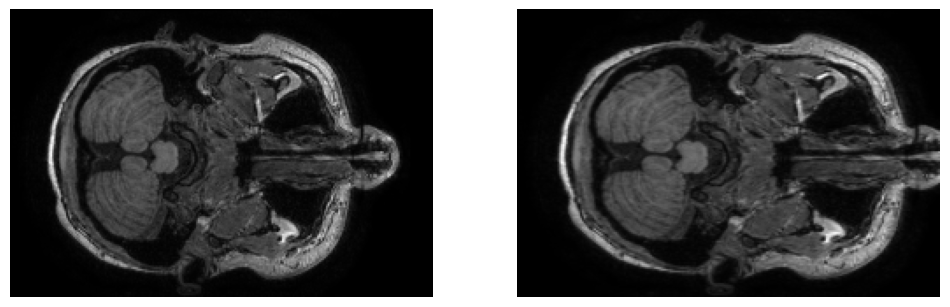

In [111]:
plt.figure(figsize=(12, 8))
mr_img1 = mr_img1 / np.max(mr_img1)
plt.subplot(1,2,1), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(rot_img, cmap='gray'), plt.axis('off')

In [98]:
def translate_tranform(img, translate_dist=(5, 5)): 
    """Translates an image for registration algorithms.
    Parameters:
    - img: 2D array 
        img to be translated
    - translate_dist: tuple of shape (x_dist, y_dist)
        length (in pixels) along which x and y are going to be translated 
    Returns: trans_img, Translated img (2D array)
    """
    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    trans_img = np.zeros(img.shape)
    
    x_new = x + translate_dist[0]
    y_new = y + translate_dist[1]
    x_new, y_new = np.meshgrid(x_new, y_new)
    new_points = np.column_stack((x_new.flatten(), y_new.flatten()))
    
    print(new_points.dtype)
    
    trans_img = bilinear_interpolation(img, new_points)
    trans_img = np.reshape(trans_img, img.shape)
    
    return trans_img 

## Metrics

In [ ]:
def calculate_mutual_information(img1, img2): 
    """Calculates the mutual entropy of the two images"""
    
    img1 = img1.flatten()
    img2 = img2.flatten()
    bins = 256
    
    hist_2d, _, _ = np.histogram2d(img1, img2, bins=bins)

    # Calculate marginal histograms
    hist_1d_image1, _ = np.histogram(img1, bins=bins)
    hist_1d_image2, _ = np.histogram(img2, bins=bins)

    # Convert histograms to probabilities
    pxy = hist_2d / float(np.sum(hist_2d))
    px = hist_1d_image1 / float(np.sum(hist_1d_image1))
    py = hist_1d_image2 / float(np.sum(hist_1d_image2))

    # Compute mutual information
    mi = np.sum(pxy * np.log2(pxy / (np.outer(px, py) + 1e-10)))

    return mi



In [99]:
moved_img = translate_tranform(mr_img1[:, :, 100], (25, 25))

float64


(<AxesSubplot:>,
 (-0.5, 240.5, 163.5, -0.5))

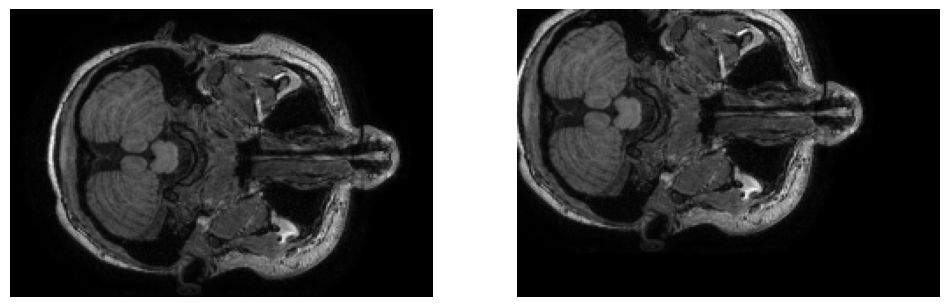

In [ ]:
plt.figure(figsize=(12, 8))
mr_img1 = mr_img1 / np.max(mr_img1)
plt.subplot(1,2,1), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(moved_img, cmap='gray'), plt.axis('off')

In [ ]:
print(np.min(mr_img1[:, :, 100]), np.max(mr_img1[:, :, 100]))
print(np.min(moved_img), np.max(moved_img))

0.0 0.6511850752966393
0.0 1.0


In [ ]:
mutual_information = calculate_mutual_information(mr_img1[:, :, 100],moved_img)
print(f"Mutual Information: {mutual_information}")